In [7]:
# https://hemtools.readthedocs.io/en/latest/content/Bioinformatics_Core_Competencies/Volcanoplot.html
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [8]:
dataset = "D5"
filename = f"{dataset} v cntl.xlsx"
p_col_name = f'P-value ({dataset} vs Control)'
fdr_col_name = f'FDR step up ({dataset} vs Control)'
fold_change_col_name = f'Fold change ({dataset} vs Control)'

df = pd.read_excel(filename)
df.head()

,Gene ID,Gene name,P-value (D5 vs Control),FDR step up (D5 vs Control),Ratio (D5 vs Control),Fold change (D5 vs Control),LSMean(D5) (D5 vs Control),LSMean(Control) (D5 vs Control)
0,0610005C13Rik,0610005C13Rik,0.77593,?,0.780019,-1.28202,4.736627,6.072451
1,0610006L08Rik,0610006L08Rik,0.948803,?,1.126167,1.126167,2.607497,2.315373
2,0610009B22Rik,0610009B22Rik,0.003554,0.051997,0.291907,-3.425747,18.823511,64.484591
3,0610009E02Rik,0610009E02Rik,0.039973,?,6.50813,6.50813,10.849724,1.667103
4,0610009L18Rik,0610009L18Rik,0.236376,0.552507,0.59912,-1.669115,12.982673,21.669576


In [9]:
print(df.columns)
print(df[p_col_name].dtype)
df[p_col_name] = pd.to_numeric(df[p_col_name], errors='coerce')

Index(['Gene ID', 'Gene name', 'P-value (D5 vs Control)',
       'FDR step up (D5 vs Control)', 'Ratio (D5 vs Control)',
       'Fold change (D5 vs Control)', 'LSMean(D5) (D5 vs Control)',
       'LSMean(Control) (D5 vs Control)'],
      dtype='object')
object


In [10]:
# Lets filter out the rows where the 'FDR step up (D5 vs Control)' == '?'
print('Shape of df before filtering: ', df.shape)
df = df[df[fdr_col_name] != '?']
print('Shape of df after filtering FDR step up, "?": ', df.shape)

# Now we must filter for 'FDR step up (D5 vs Control)' <= 0.05
# df = df[df['FDR step up (D5 vs Control)'] <= 0.05]
# print('Shape of df after filtering FDR step up cutoff, "<= 0.05": ', df.shape)

# Now we must filter for 'P-value (D5 vs Control)' <= 0.05
df = df[df[p_col_name] <= 0.05]
print('Shape of df after filtering P-value cutoff, "<= 0.05": ', df.shape)

# print out some statistics of the Fold Change
print('Mean: ', df[fold_change_col_name].mean())
print('Median: ', df[fold_change_col_name].median())
print('Std: ', df[fold_change_col_name].std())

Shape of df before filtering:  (29383, 8)
Shape of df after filtering FDR step up, "?":  (17977, 8)
Shape of df after filtering P-value cutoff, "<= 0.05":  (3580, 8)
Mean:  -18763254.929371506
Median:  1.327257246272845
Std:  1121933256.9127567


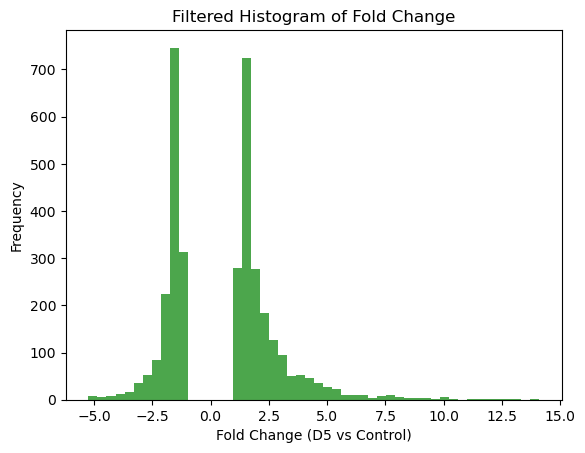

In [11]:
# Removing extreme outliers for visualization and analysis
q_low = df[fold_change_col_name].quantile(0.01)
q_high = df[fold_change_col_name].quantile(0.99)

df = df[(df[fold_change_col_name] > q_low) & (df[fold_change_col_name] < q_high)]

# Replot histogram with filtered data
plt.hist(df[fold_change_col_name], bins=50, color='green', alpha=0.7)
plt.title('Filtered Histogram of Fold Change')
plt.xlabel('Fold Change (D5 vs Control)')
plt.ylabel('Frequency')
plt.show()


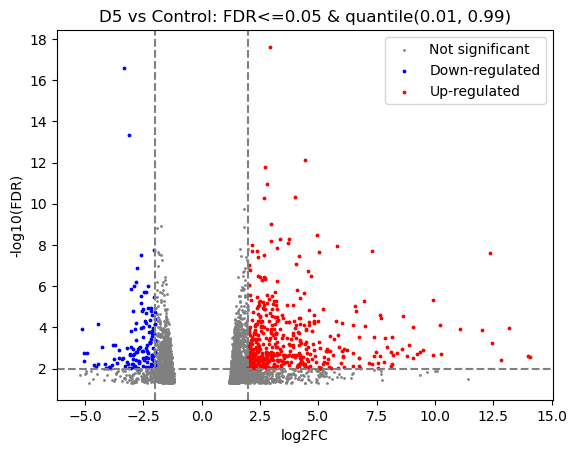

In [12]:
# # Handling non-numeric and zero values before applying log2
df[fold_change_col_name] = pd.to_numeric(df[fold_change_col_name], errors='coerce').replace(0, np.nan)

# # Adding a small value to handle zeroes and negative values if any
# df['Fold change (D5 vs Control)'] += 1e-6

# Applying log2 transformation
# df['logFC'] = np.log2(df['Fold change (D5 vs Control)'])
df['logFC'] = df[fold_change_col_name]

# Plot non-significant points
plt.scatter(
    x=df['logFC'],
    y=df[p_col_name].apply(lambda x: -np.log10(x)),
    s=1,
    label="Not significant",
    color='grey'
)

# Highlight down- or up-regulated genes
down = df[(df['logFC'] <= -2) & (df[p_col_name] <= 0.01)]
up = df[(df['logFC'] >= 2) & (df[p_col_name] <= 0.01)]

plt.scatter(
    x=down['logFC'],
    y=down[p_col_name].apply(lambda x: -np.log10(x)),
    s=3,
    label="Down-regulated",
    color="blue"
)
plt.scatter(
    x=up['logFC'],
    y=up[p_col_name].apply(lambda x: -np.log10(x)),
    s=3,
    label="Up-regulated",
    color="red"
)

# Axes and labels
plt.title(f"{dataset} vs Control: FDR<=0.05 & quantile(0.01, 0.99)")
plt.xlabel("log2FC")
plt.ylabel("-log10(FDR)")
plt.axvline(x=-2, color="grey", linestyle="--")
plt.axvline(x=2, color="grey", linestyle="--")
plt.axhline(y=2, color="grey", linestyle="--")  # Threshold for significance; adjust if different

# Legend and plot display
plt.legend()
plt.show()